In [ ]:
## LIBRERIAS
from google.colab import drive, files
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
import keras_tuner as kt
from keras import Model, Sequential
from keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Rescaling, GlobalAveragePooling2D, RandomFlip, Input, RandomRotation
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import random
import seaborn as sn
import os
random.seed(1234)

In [ ]:
## Cargamos Drive e importamos las imágenes de train y test
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/Juane/Sentinel2LULC_354.zip" -d "/content"
!unzip "/content/drive/MyDrive/Juane/Sentinel2LULC_Test.zip" -d "/content"

In [ ]:
## Renombramos las carpetas para que tf las lea en orden
dirnames = sorted(os.listdir("Sentinel2LULC_354"))
for dir in dirnames:
  newname = ""

  if (len(dir.split('_')[0]) == 1):
    newname = '0'+dir.split('_')[0]
  else:
    newname = dir.split('_')[0]

  os.rename("Sentinel2LULC_354/"+dir,"Sentinel2LULC_354/"+newname)

In [ ]:
## Leemos las imágenes de train, validacion y test

training = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_354",
  validation_split=0.2,
  subset="training",
  seed=1234,
  image_size=(224, 224),
  batch_size = 32)

validation = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_354",
  validation_split=0.2,
  subset="validation",
  seed=1234,
  image_size=(224, 224),
  batch_size = 32)

test = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_Test",
  shuffle=False,
  labels=None,
  image_size=(224, 224),
  batch_size = 32)


Found 10266 files belonging to 29 classes.
Using 8213 files for training.
Found 10266 files belonging to 29 classes.
Using 2053 files for validation.
Found 1618 files belonging to 1 classes.


In [ ]:
## Clase para rotar imagenes solamente en multiplos de 90 (https://errorsfixing.com/rotate-image-for-data-augmentation-using-tf-keras-only-in-specific-angles/)
class Rotate90Randomly(tf.keras.layers.experimental.preprocessing.PreprocessingLayer):
    def __init__(self):
        super(Rotate90Randomly, self).__init__()

    def call(self, x, training=False):
        def random_rotate():
            rotation_factor = tf.random.uniform([], minval=0,
                                                maxval=4, dtype=tf.int32)
            return tf.image.rot90(x, k=rotation_factor)

        training = tf.constant(training, dtype=tf.bool)
        
        rotated = tf.cond(training, random_rotate, lambda: x)
        rotated.set_shape(rotated.shape)
        return rotated

In [ ]:
## Estimación de los hiperparámetros del compilador

def model_builder(hp):
  '''
  Args:
    hp - Keras tuner object
  '''
  augmentation = Sequential([
        RandomFlip(),
        Rotate90Randomly()
  ])
  base_model = tf.keras.applications.EfficientNetB2(include_top=False,
                                                    weights='imagenet',
                                                    pooling='avg')
  base_model.trainable = False
  entrada = Input(shape=(224,224,3))
  prediction_layer = Dense(29, activation="softmax")
  model = Sequential([
    entrada,
    augmentation,
    base_model,
    BatchNormalization(),
    Dropout(0.2),
    prediction_layer
  ])

  # Tuneamos el learning rate y el optimizador
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2,1e-3,1e-4])
  hp_amsgrad = hp.Choice('amsgrad', values=[True,False])
  model.compile(optimizer=Adam(learning_rate=hp_learning_rate,amsgrad=hp_amsgrad),
                loss=SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
  return model

# Instanciamos el tuner
tuner = kt.Hyperband(model_builder, 
                     objective='val_accuracy', 
                     max_epochs=25,
                     factor=3, 
                     directory="/content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/",
                     project_name='khyperbandEfficientNetB2Rotation')

print(tuner.search_space_summary())

# Ejecutamos el tuner
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(training,validation_data=validation,epochs=25, callbacks=[stop_early])
best_hp=tuner.get_best_hyperparameters()[0]

print(best_hp.get('learning_rate'))
print(best_hp.get('amsgrad'))

Trial 6 Complete [00h 04m 05s]
val_accuracy: 0.687286913394928

Best val_accuracy So Far: 0.6960545778274536
Total elapsed time: 00h 24m 57s
INFO:tensorflow:Oracle triggered exit
0.001
0


2022/03/18 17:05:54 INFO mlflow.tracking.fluent: Experiment with name 'EfficientNetB2 con DataAugmentation (ImageNet)' does not exist. Creating a new experiment.


Epoch 1/25
257/257 [==============================] - 80s 267ms/step - loss: 1.6845 - accuracy: 0.5042 - val_loss: 1.3310 - val_accuracy: 0.6410
Epoch 2/25
257/257 [==============================] - 66s 256ms/step - loss: 1.1526 - accuracy: 0.6346 - val_loss: 0.9930 - val_accuracy: 0.6814
Epoch 3/25
257/257 [==============================] - 66s 255ms/step - loss: 1.0185 - accuracy: 0.6755 - val_loss: 0.9147 - val_accuracy: 0.6990
Epoch 4/25
257/257 [==============================] - 66s 256ms/step - loss: 0.9684 - accuracy: 0.6867 - val_loss: 0.9194 - val_accuracy: 0.6980
Epoch 5/25
257/257 [==============================] - 66s 257ms/step - loss: 0.9223 - accuracy: 0.6940 - val_loss: 0.8994 - val_accuracy: 0.7087
Epoch 6/25
257/257 [==============================] - 67s 258ms/step - loss: 0.8580 - accuracy: 0.7150 - val_loss: 0.8456 - val_accuracy: 0.7199
Epoch 7/25
257/257 [==============================] - 67s 258ms/step - loss: 0.8521 - accuracy: 0.7111 - val_loss: 0.8435 - val_ac

2022/03/18 17:36:10 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


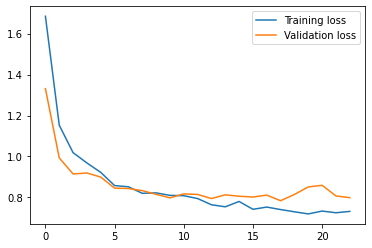

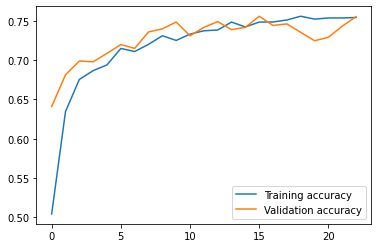

In [ ]:
## Función que muestra la evolución de las accuracy de train y validacion
## durante el entrenamiento.
def mostrarEvolucion(hist):

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()

## Creamos el modelo con las capas de Data Augmentation.
## Solo RandomFlip parece ir bien. 
augmentation = Sequential([
        RandomFlip(),
        Rotate90Randomly()
])


## Vamos a entrenar usando la red EfficietNetB2
base_model = tf.keras.applications.EfficientNetB2(include_top=False,
                                                  weights='imagenet',
                                                  pooling='avg')

base_model.trainable = False

## Capa de entrada
entrada = Input(shape=(224,224,3))

## Capa de normalizacion
normalization = Rescaling(1./255)

## Capa de salida
prediction_layer = Dense(29, activation="softmax")

## Creamos nuestro modelo final juntando todos los submodelos/capas
## anteriores
model = Sequential([
  entrada,
  augmentation,
  base_model,
  BatchNormalization(),
  Dropout(0.2),
  prediction_layer
])

opt = Adam(learning_rate=0.001)
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("EfficientNetB2 con DataAugmentation (ImageNet)")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=5,restore_best_weights=True)
  history = model.fit(training,
                    epochs=25,
                    validation_data=validation,
                    callbacks=callback)

  mostrarEvolucion(history)

Epoch 1/25
257/257 [==============================] - 265s 961ms/step - loss: 1.5036 - accuracy: 0.5897 - val_loss: 2.2006 - val_accuracy: 0.4228
Epoch 2/25
257/257 [==============================] - 240s 934ms/step - loss: 0.8120 - accuracy: 0.7450 - val_loss: 0.6651 - val_accuracy: 0.7803
Epoch 3/25
257/257 [==============================] - 240s 933ms/step - loss: 0.5976 - accuracy: 0.8026 - val_loss: 0.4975 - val_accuracy: 0.8212
Epoch 4/25
257/257 [==============================] - 240s 932ms/step - loss: 0.4988 - accuracy: 0.8299 - val_loss: 0.5198 - val_accuracy: 0.8237
Epoch 5/25
257/257 [==============================] - 239s 931ms/step - loss: 0.4508 - accuracy: 0.8478 - val_loss: 0.4629 - val_accuracy: 0.8456
Epoch 6/25
257/257 [==============================] - 240s 933ms/step - loss: 0.3803 - accuracy: 0.8726 - val_loss: 0.3895 - val_accuracy: 0.8656
Epoch 7/25
257/257 [==============================] - 240s 932ms/step - loss: 0.3460 - accuracy: 0.8796 - val_loss: 0.4316 -

2022/03/18 18:36:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


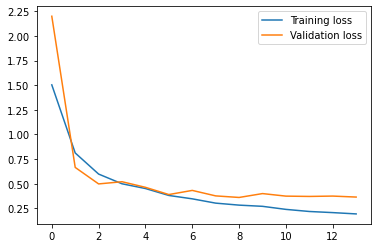

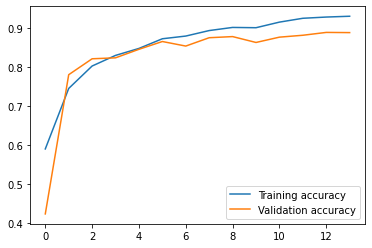

In [ ]:
## FINE TUNING: Volvemos a entrenar descongelando algunas capas (menos las BatchNormalization)

def unfreeze_model(model):
    for layer in model.layers[-20:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True

    opt = Adam(learning_rate=1e-4)
    model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])


unfreeze_model(model)

with mlflow.start_run():
  callback = EarlyStopping(patience=5,restore_best_weights=True)
  history = model.fit(training,
                    epochs=25,
                    validation_data=validation,
                    callbacks=callback)

  mostrarEvolucion(history)

In [ ]:
## Predecimos las clases
y_pred = model.predict(test)
classes = np.argmax(y_pred, axis=1)
classes = np.array(classes)
classes = classes + 1
print(classes)

[10 10 10 ...  9  9 15]


In [ ]:
## Creamos el csv con los resultados
d = {'id.jpg': sorted(os.listdir("Sentinel2LULC_Test")), 'label': classes}
df = pd.DataFrame(data=d)
df.to_csv('EfficientNetB2_ImageNet_Random90Rotation.csv', index=False)
files.download('EfficientNetB2_ImageNet_Random90Rotation.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

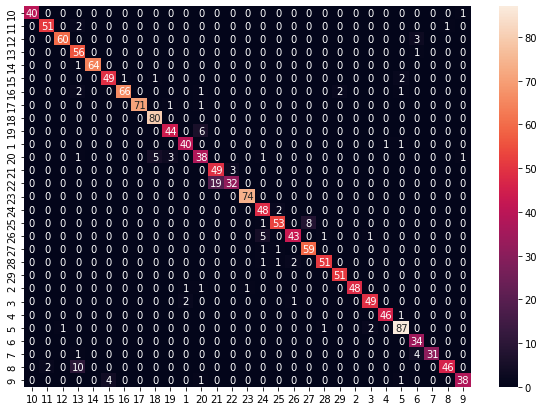

In [ ]:
## Sacamos la matriz de confusion

clases = []
dirname = sorted(os.listdir("Sentinel2LULC_Test"))
for names in dirname:
  clases.append(names.split('_')[0])

clases = [int(x) for x in clases]

matrix = confusion_matrix(clases, list(classes),labels=[i for i in range(10,20)]+[1]+[i for i in range(20,30)]+[i for i in range(2,10)])

df_cm = pd.DataFrame(matrix, index = [i for i in range(10,20)]+[1]+[i for i in range(20,30)]+[i for i in range(2,10)],
                  columns = [i for i in range(10,20)]+[1]+[i for i in range(20,30)]+[i for i in range(2,10)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)